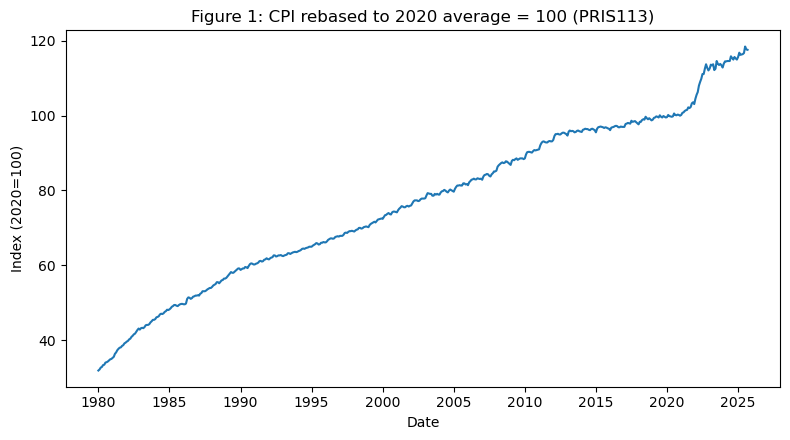

In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

BASE = "https://api.statbank.dk/v1"

class DstApi:
    def __init__(self, table_id: str):
        self.table_id = table_id.upper()

    def tableinfo(self, language: str = "da") -> dict:
        """Fetch metadata for the table."""
        payload = {"table": self.table_id, "format": "JSON", "lang": language}
        r = requests.post(f"{BASE}/tableinfo", json=payload)
        r.raise_for_status()
        return r.json()

    def get_csv(self, params: dict) -> pd.DataFrame:
        """
        Fetch data as CSV and return a pandas DataFrame.
        """
        r = requests.post(f"{BASE}/data", json=params)
        r.raise_for_status()
        return pd.read_csv(StringIO(r.text), sep=";", decimal=",") 

def pick_cpi_value_id(meta: dict) -> tuple[str, str]:
    """
    We find the variable and value-id that correspond to the 'Forbrugerprisindeks' aggregate in PRIS113.
    Returns (variable_code, value_id). Raises if not found.
    """
    for v in meta.get("variables", []):
        texts = [val.get("text", "").lower() for val in v.get("values", [])]
        ids   = [val.get("id") for val in v.get("values", [])]
        for val_text, val_id in zip(texts, ids):
            if "forbrugerprisindeks" in val_text:
                return v["id"], val_id
    raise RuntimeError("Could not find 'Forbrugerprisindeks' in PRIS113 metadata. Inspect tableinfo() output.")

def parse_time_column(series: pd.Series) -> pd.Series:
    """
    Convert DST monthly labels like '2020M01' into pandas Timestamps.
    """
    def _parse(s: str):
        s = str(s).strip().replace("M", "-")  # '2020M01' -> '2020-01'
        try:
            return pd.to_datetime(s, format="%Y-%m")
        except Exception:
            return pd.to_datetime(s, errors="coerce")
    return series.apply(_parse)

# ---------- 1) Setup and metadata ----------
api = DstApi("PRIS113")
meta = api.tableinfo(language="da")

# Choose CPI aggregate
var_code, cpi_id = pick_cpi_value_id(meta)

# Build request params: CPI aggregate + all months
params = {
    "table": "PRIS113",
    "format": "CSV",
    "lang": "da",
    "variables": [
        {"code": var_code, "values": [cpi_id]},
        # Time may be named 'TID' in StatBank tables
        {"code": meta["time"]["id"] if "time" in meta else "TID", "values": ["*"]},
    ],
}

# ---------- 2) Fetch data ----------
raw = api.get_csv(params)

# ---------- 3) Tidy / validation ----------
# Identify time and value columns robustly
time_candidates  = [c for c in raw.columns if c.lower() in ("tid", "time", "måned", "maaned", "month")]
value_candidates = [c for c in raw.columns if c.lower() in ("indhold", "value", "values", "data")]
if not time_candidates or not value_candidates:
    raise RuntimeError(f"Could not infer time/value columns from: {list(raw.columns)}")

tcol = time_candidates[0]
vcol = value_candidates[0]

df = raw.copy()
df["date"] = parse_time_column(df[tcol])
df["cpi_2015eq100"] = pd.to_numeric(df[vcol], errors="coerce")

# Sanity checks
if df["date"].isna().all():
    raise RuntimeError("All parsed dates are NaT. Check the time column format in the fetched CSV.")
if df["cpi_2015eq100"].isna().all():
    # This usually means decimal commas were not parsed; but we set decimal="," above.
    raise RuntimeError("All CPI values are NaN. Check parsing (separator/decimal) and the selected series.")

df = df.sort_values("date").reset_index(drop=True)

# ---------- 4) Rebase to 2020 average = 100 ----------
base_2020 = df.loc[df["date"].dt.year == 2020, "cpi_2015eq100"].mean()
if pd.isna(base_2020):
    raise RuntimeError("No 2020 observations found to compute the 2020-average base.")
df["cpi_2020avg_100"] = df["cpi_2015eq100"] / base_2020 * 100.0

# ---------- 5) Inflation rates ----------
df["mom_inflation_pct"] = df["cpi_2015eq100"].pct_change(1) * 100.0      # month-over-month
df["yoy_inflation_pct"] = df["cpi_2015eq100"].pct_change(12) * 100.0     # year-over-year

# ---------- 6) Plots ----------
plt.figure(figsize=(8, 4.5))
plt.plot(df["date"], df["cpi_2020avg_100"])
plt.title("Figure 1: CPI rebased to 2020 average = 100 (PRIS113)")
plt.xlabel("Date"); plt.ylabel("Index (2020=100)")
plt.tight_layout(); plt.show()

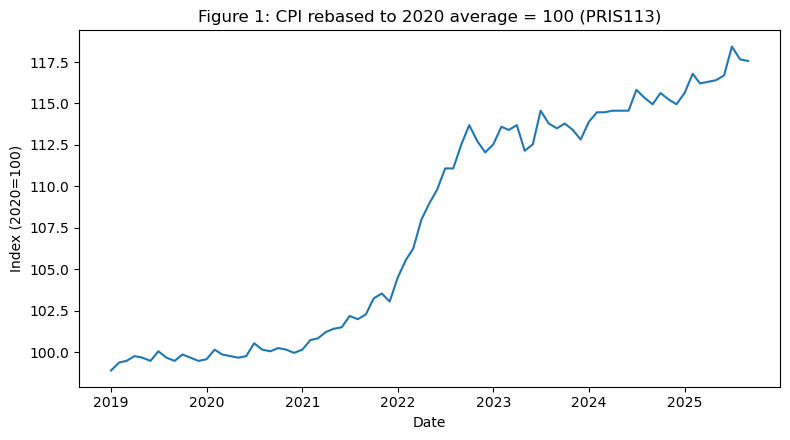

In [4]:
# Begræns til 2019 og frem
df_2019 = df[df["date"].dt.year >= 2019]

plt.figure(figsize=(8, 4.5))
plt.plot(df_2019["date"], df_2019["cpi_2020avg_100"])
plt.title("Figure 1: CPI rebased to 2020 average = 100 (PRIS113)")
plt.xlabel("Date")
plt.ylabel("Index (2020=100)")
plt.tight_layout()
plt.show()
